# Dummy example

I want to learn a function, that preserves the topology the latent space

In [7]:
import gudhi
import numpy as np
import matplotlib.pyplot as plt

from torch_topological.nn import VietorisRipsComplex, WassersteinDistance

import torch.nn as nn
import torch

from gudhi.wasserstein import wasserstein_distance
from torch.optim.lr_scheduler import LambdaLR
from sklearn.decomposition import PCA

In [8]:
def wasserstein_based_loss_gudhi(features_1, features_2):
    rips = gudhi.RipsComplex(points=features_1, max_edge_length=0.5)
    rips_1 = gudhi.RipsComplex(points=features_2, max_edge_length=0.5)
    # for the first Point cloud
    st = rips.create_simplex_tree(max_dimension=2)
    st.compute_persistence()
    i = st.flag_persistence_generators()
    if len(i[1]) > 0:
        i1 = torch.tensor(i[1][0])  # pytorch sometimes interprets it as a tuple otherwise
    else:
        i1 = torch.empty((0, 4), dtype=int)
    # for the seconds Point cloud
    st_1 = rips_1.create_simplex_tree(max_dimension=2)
    st_1.compute_persistence()
    i_1 = st_1.flag_persistence_generators()
    if len(i_1[1]) > 0:
        i1_1 = torch.tensor(i_1[1][0])
    else:
        i1_1 = torch.empty((0, 4), dtype=int)
        
    # Same as the finite part of st.persistence_intervals_in_dimension(1), but differentiable
    diag = torch.norm(features_1[i1[:, (0, 2)]] - features_1[i1[:, (1, 3)]], dim=-1)
    diag1 = torch.norm(features_2[i1_1[:, (0, 2)]] - features_2[i1_1[:, (1, 3)]], dim=-1)

    
    wasser = wasserstein_distance(diag, 
                                  diag1, 
                                  order=1, 
                                  enable_autodiff=True)
    print("wasser", wasser)
    return wasser


In [48]:
def wasserstein_loss(features_1, features_2):
    vr = VietorisRipsComplex(dim=1, p=2)
    vr_2 = VietorisRipsComplex(dim=1, p=2)
    distance = WassersteinDistance(p=2, q=1)
    # for the first Point cloud
    pi_1 = vr(features_1)
    # print(pi_1)
    pi_2 = vr_2(features_2)
    print(pi_1[0].diagram.detach().numpy())
    plt.scatter(pi_1[0].diagram.detach().numpy()[:, 0], 
                pi_1[0].diagram.detach().numpy()[:, 1])
    wasser = distance(pi_1, pi_2)
    print("wasser", wasser)
    return wasser

In [49]:
def train_network(network, X, Z, n_epochs=100, lr=1e-3, loss_type="wasser"):
    losses = []
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    scheduler = LambdaLR(optimizer, 
                         lr_lambda=lambda epoch: 0.99 ** epoch)
    MSE = nn.MSELoss()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        view_1, view_2 = network(X), network(Z)
        if loss_type == "wasser":
            loss = wasserstein_loss(view_1, view_2)
        elif loss_type == "mse":
            loss = MSE(view_1, view_2)
        else:
            loss = wasserstein_loss(view_1, view_2) + MSE(view_1, view_2)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        scheduler.step()
        # Draw every 100 epochs
        if epoch % 10 == 0:
            colors = np.arange(view_1.shape[0])
            pca = PCA(n_components=2)
            all_views = torch.cat([view_1, view_2])
            all_views = pca.fit_transform(all_views.detach().numpy())

            view_1_pca = all_views[:len(view_1)]
            view_2_pca = all_views[len(view_1):]
            
            plt.scatter(view_1_pca[:, 0], view_1_pca[:, 1], c=colors, cmap="viridis", alpha=0.5)
            plt.scatter(view_2_pca[:, 0], view_2_pca[:, 1], marker="x", c=colors, cmap="viridis", alpha=0.5)
            plt.show()
    return losses

[[0.         0.03408924]
 [0.         0.03967678]
 [0.         0.0448143 ]
 [0.         0.04831833]
 [0.         0.05486   ]
 [0.         0.05851893]
 [0.         0.05893702]
 [0.         0.06617546]
 [0.         0.06633738]
 [0.         0.07048358]
 [0.         0.07207081]
 [0.         0.07271723]
 [0.         0.08602538]
 [0.         0.10680465]
 [0.         0.10680964]
 [0.         0.10753916]
 [0.         0.11189627]
 [0.         0.12777051]
 [0.         0.12788758]
 [0.         0.13898227]
 [0.         0.14548846]
 [0.         0.14630236]
 [0.         0.15087728]
 [0.         0.15725894]
 [0.         0.1589723 ]
 [0.         0.16734606]
 [0.         0.17895165]
 [0.         0.180275  ]
 [0.         0.18333949]
 [0.         0.18427762]
 [0.         0.18853569]
 [0.         0.19261405]
 [0.         0.19512999]
 [0.         0.19665444]
 [0.         0.19693965]
 [0.         0.2024918 ]
 [0.         0.20259151]
 [0.         0.20349094]
 [0.         0.20579074]
 [0.         0.219779  ]


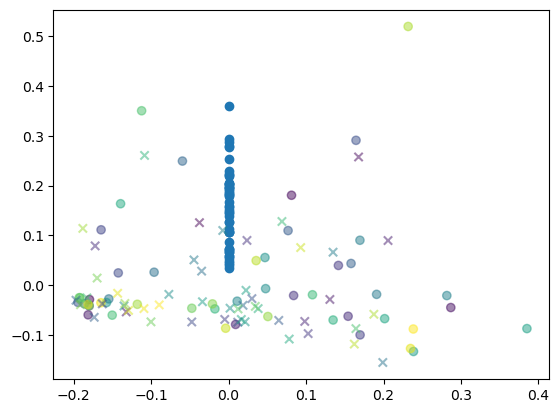

[[0.         0.00489729]
 [0.         0.01533485]
 [0.         0.02631217]
 [0.         0.04441705]
 [0.         0.05693739]
 [0.         0.05728231]
 [0.         0.07020687]
 [0.         0.08085576]
 [0.         0.08568053]
 [0.         0.09732699]
 [0.         0.10445625]
 [0.         0.10527938]
 [0.         0.11222611]
 [0.         0.11283194]
 [0.         0.11426862]
 [0.         0.11800794]
 [0.         0.12022226]
 [0.         0.12295508]
 [0.         0.12686756]
 [0.         0.13344784]
 [0.         0.13353571]
 [0.         0.13405466]
 [0.         0.13563073]
 [0.         0.13613135]
 [0.         0.13980766]
 [0.         0.14250405]
 [0.         0.14377378]
 [0.         0.14528398]
 [0.         0.15161732]
 [0.         0.15338506]
 [0.         0.15640457]
 [0.         0.15775675]
 [0.         0.15874389]
 [0.         0.18051925]
 [0.         0.1805348 ]
 [0.         0.18449669]
 [0.         0.19903947]
 [0.         0.20714314]
 [0.         0.20796378]
 [0.         0.22476216]


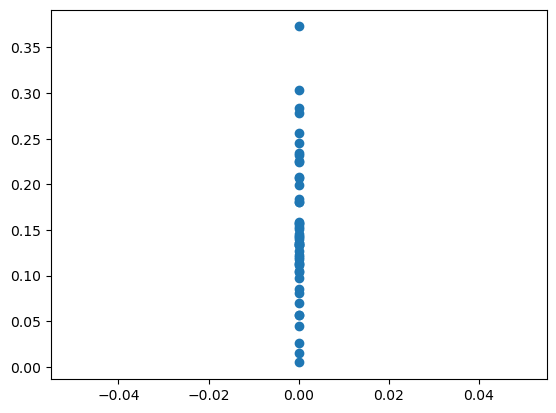

In [50]:
X = torch.tensor(np.random.rand(50, 200), dtype=torch.float32)
Y = torch.tensor(np.random.rand(50, 200), dtype=torch.float32)

network = nn.Sequential(nn.Linear(200, 10),
                        nn.ReLU(),)

losses = train_network(network, X, Y, n_epochs=2, lr=1e-3)


Text(0.5, 1.0, 'Wasserstein loss on persistence diagrams in the latent space')

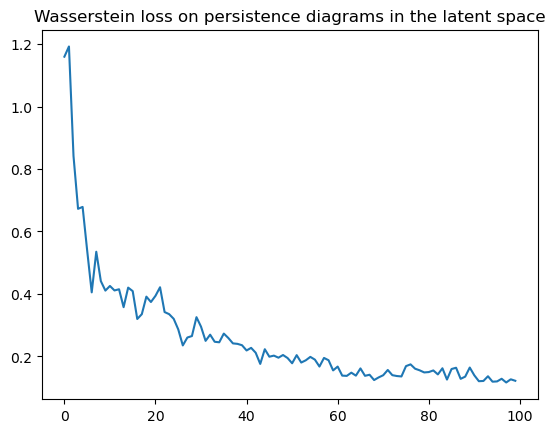

In [12]:
plt.plot(losses)
plt.title("Wasserstein loss on persistence diagrams in the latent space")